# Singular Value Decomposition - II (SVD in practice)

In [48]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.datasets as sk_data
import sklearn.metrics as metrics
import scipy.sparse.linalg as linalg


from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD

#import matplotlib as mpl
import seaborn as sns
%matplotlib inline

## Low rank data

The data is generated using the sample data generators summarized at: 

http://scikit-learn.org/stable/modules/classes.html#module-sklearn.datasets

More specifically, we use the datasets.make_low_rank_matrix() function: 

http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_low_rank_matrix.html#sklearn.datasets.make_low_rank_matrix

This function generates  a mostly low rank matrix with bell-shaped singular values

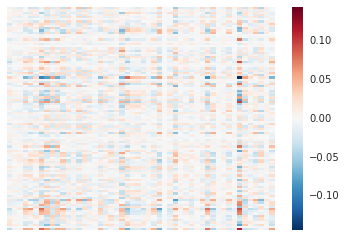

In [49]:
data = sk_data.make_low_rank_matrix(n_samples=100, n_features=50, effective_rank=2, tail_strength=0.0, random_state=None)
sns.heatmap(data, xticklabels=False, yticklabels=False, linewidths=0)

## Numpy Singular Value Decomposition

We start our analysis with SVD using the (non-sparse) SVD decomposition provided by numpy:
http://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.svd.html

(100, 100) (50,) (50, 50)


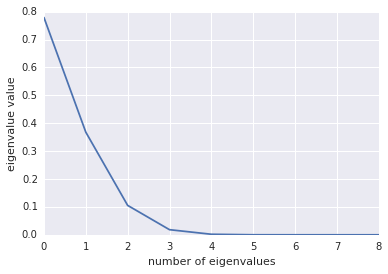

In [50]:
U, s, V = np.linalg.svd(data)
print U.shape, s.shape, V.shape
plt.plot(s[1:10])
plt.ylabel('eigenvalue value')
plt.xlabel('number of eigenvalues')

In [51]:
#printing the singular values
print s

[  1.00000000e+00   7.78800783e-01   3.67879441e-01   1.05399225e-01
   1.83156389e-02   1.93045414e-03   1.23409804e-04   4.78511739e-06
   1.12535175e-07   1.60522806e-09   1.38879488e-11   7.28669895e-14
   2.42929276e-16   2.42042859e-16   1.61931686e-16   1.57599102e-16
   9.33540347e-17   9.33540347e-17   9.33540347e-17   9.33540347e-17
   9.33540347e-17   9.33540347e-17   9.33540347e-17   9.33540347e-17
   9.33540347e-17   9.33540347e-17   9.33540347e-17   9.33540347e-17
   9.33540347e-17   9.33540347e-17   9.33540347e-17   9.33540347e-17
   9.33540347e-17   9.33540347e-17   9.33540347e-17   9.33540347e-17
   9.33540347e-17   9.33540347e-17   9.33540347e-17   9.33540347e-17
   9.33540347e-17   9.33540347e-17   9.33540347e-17   9.33540347e-17
   9.33540347e-17   9.33540347e-17   9.33540347e-17   9.33540347e-17
   4.34311342e-17   2.29525429e-17]


Computing the error in the representation by the top-k singular vectors and singular values, when the n-k singular values are set to 0 (this means that the corresponding singular vectors are also ingored).

In [52]:
errors = np.zeros(50)
for i in range(50):
    s[-1:-(i+1):-1]=np.zeros(i)
    S = np.diag(s[0:50])
    S = np.vstack([S, np.zeros((50,50)) ])
    approx_d = np.dot(U, np.dot(S,V))
    errors[i] = np.linalg.norm(data-approx_d)
print errors

[  1.72593347e-15   1.72602000e-15   1.72683644e-15   1.72511606e-15
   1.72246947e-15   1.72080286e-15   1.71869741e-15   1.71768499e-15
   1.71581036e-15   1.71400060e-15   1.71211610e-15   1.71020824e-15
   1.70756933e-15   1.70665415e-15   1.70572080e-15   1.70348456e-15
   1.70140241e-15   1.69863711e-15   1.69716489e-15   1.69496933e-15
   1.69317917e-15   1.69231058e-15   1.69056159e-15   1.68904647e-15
   1.68705473e-15   1.68468254e-15   1.68177269e-15   1.67962049e-15
   1.67679093e-15   1.67534504e-15   1.67391465e-15   1.67317653e-15
   1.67183671e-15   1.67019340e-15   1.66865536e-15   1.65958865e-15
   1.65487096e-15   1.63945811e-15   1.65013915e-15   7.28962325e-14
   1.38881322e-11   1.60528814e-09   1.12546624e-07   4.78644077e-06
   1.23502590e-04   1.93440070e-03   1.84175062e-02   1.06996267e-01
   3.83123328e-01   8.67936717e-01]


Plotting the errors as a function of the ignored singular values/vectors

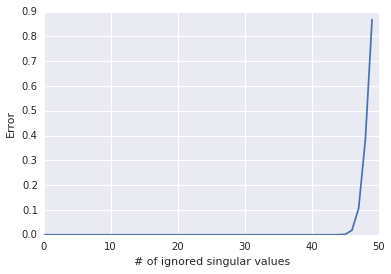

In [53]:
plt.plot(errors)
plt.ylabel('Error')
plt.xlabel('# of ignored singular values')

Plotting the data projected on the top-2 singular vectors (or making our data 2-dimensional)

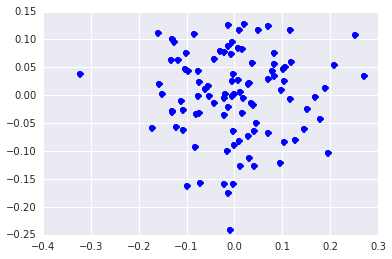

In [54]:
U, s, V = np.linalg.svd(data)
k=2

Uk = U[:,0:k]
Vk = V[0:k,:]
Sk = np.diag(s[0:k])
datak = np.dot(Uk,Sk)


plt.plot(datak[:,0],datak[:,1],'bo')


## Dimensionality reduction and clustering

### Generating high-dimensional data from k clusters

Using again the sample data generators summarized at:

http://scikit-learn.org/stable/modules/classes.html#module-sklearn.datasets

This time we use the function datasets.make_blobs(), which generates data from isotropic Gaussian blobs:

http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html#sklearn.datasets.make_blobs

In [55]:
X, y = sk_data.make_blobs(n_samples=500, centers=3, n_features=30,
                          center_box=(-4.0, 4.0),random_state=0,  cluster_std=[3.]*30)

Plotting the dataset using our favorite heatmaps

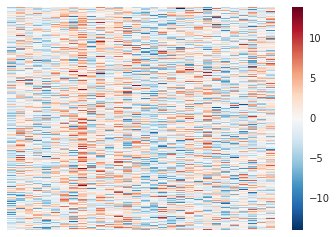

In [56]:
sns.heatmap(X,xticklabels=False, yticklabels=False, linewidths=0)

#### Projecting the data into the 2-d space using SVD

In [57]:
def svd_projection(data,k):
    U, s, V = np.linalg.svd(data)
    Uk = U[:,0:k]
    Vk = V[0:k,:]
    Sk = np.diag(s[0:k])
    datak = np.dot(Uk,Sk)
    return datak

Taking the projection of the data in the top-k (k=5) right singular vectors

In [58]:
svdX = svd_projection(X,5)

Projecting our data into pairs of dimensions 

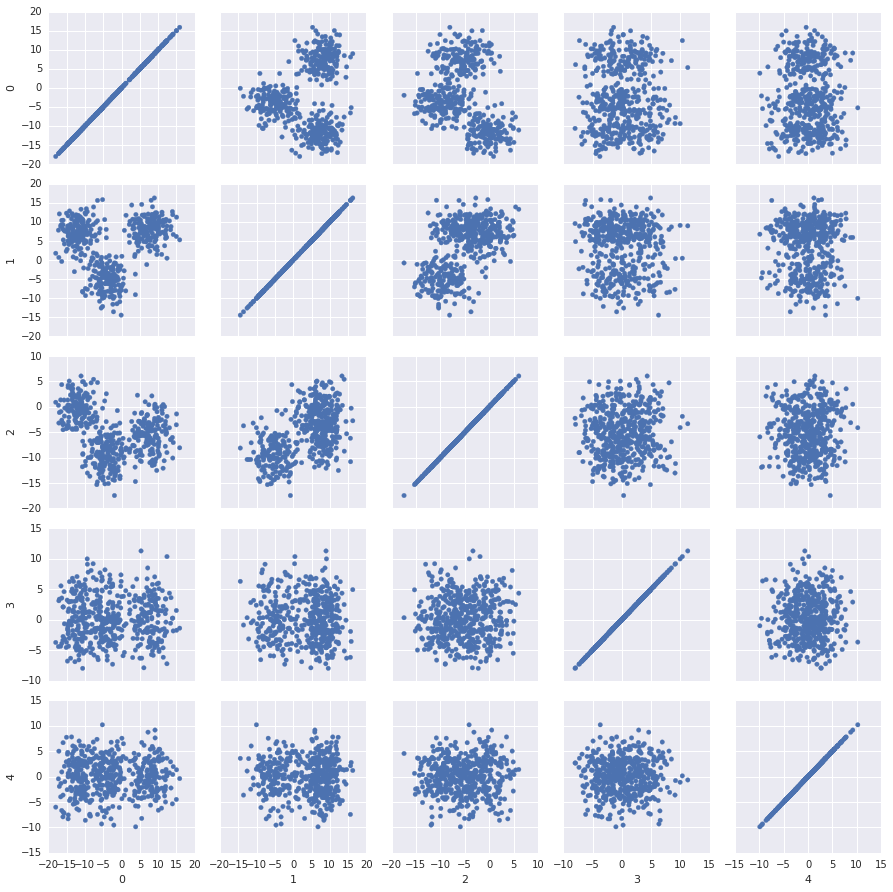

In [59]:
svdX_df = pd.DataFrame(svdX)
g = sns.PairGrid(svdX_df)
g.map(plt.scatter)

Showing the low-dimensional dataset in a heatmap

(100, 50)


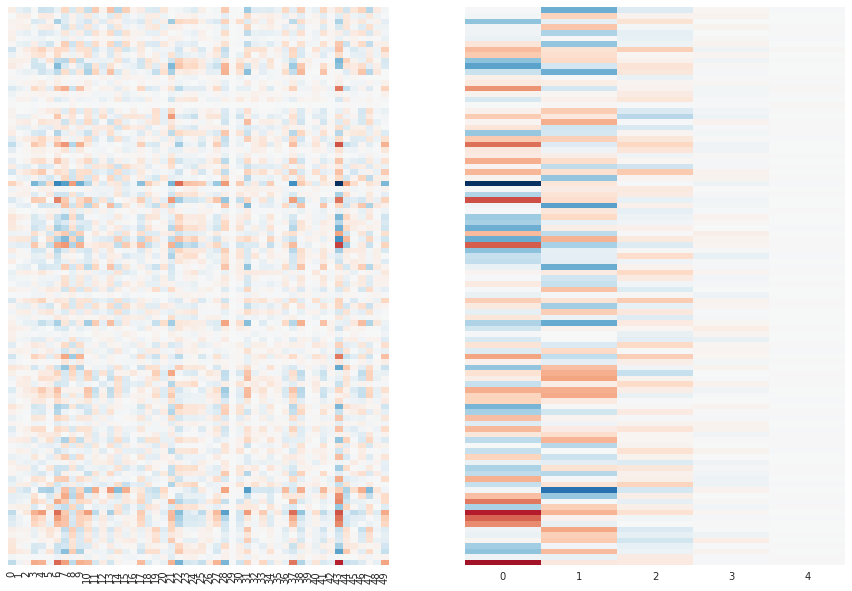

In [60]:
k=5
U, s, V = np.linalg.svd(data)
Uk = U[:,0:k]
Vk = V[0:k,:]
Sk = np.diag(s[0:k])
newX = np.dot(np.dot(Uk,Sk),Vk)
print newX.shape

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(15,10))
sns.heatmap(newX, xticklabels=True, yticklabels=False, linewidths=0, ax=ax1,  cbar=False)
sns.heatmap(np.dot(Uk,Sk), xticklabels=True, yticklabels=False, linewidths=0, ax=ax2, cbar=False)

### Clustering the original data

0.445161222494


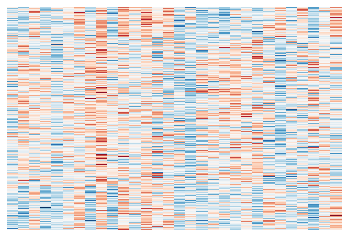

In [61]:
kmeans = KMeans(init='k-means++', n_clusters=3, n_init=1)
kmeans.fit_predict(X)
centroids = kmeans.cluster_centers_
labels = kmeans.labels_
error = kmeans.inertia_

idx = np.argsort(labels)
rX = X[idx,:]
sns.heatmap( rX,xticklabels=False, yticklabels=False, linewidths=0,cbar=False)

ri = metrics.adjusted_rand_score(labels,y)
print ri


### Clustering the projected data

0.993981940182


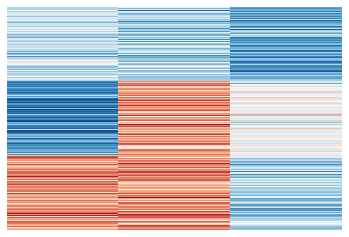

In [62]:
svdX = svd_projection(X,3)


kmeans = KMeans(init='k-means++', n_clusters=3, n_init=1)
kmeans.fit_predict(svdX)
centroids = kmeans.cluster_centers_
labels = kmeans.labels_
error = kmeans.inertia_

idx = np.argsort(labels)
rX = svdX[idx,:]
sns.heatmap( rX,xticklabels=False, yticklabels=False, linewidths=0,cbar=False)

ri = metrics.adjusted_rand_score(labels,y)
print ri



## Using real data (20 Newsgroup data)

In [63]:
from sklearn.datasets import fetch_20newsgroups


categories = ['sci.med', 'sci.space','rec.sport.baseball']
news_data = fetch_20newsgroups(subset='train', categories=categories)
stemmed_data = news_data.data


In [64]:
print news_data.target_names
print news_data.target



['rec.sport.baseball', 'sci.med', 'sci.space']
[2 1 2 ..., 1 0 0]


### Stemming the data using the Snowball Stemmer (after tokenizing):   http://www.nltk.org/howto/stem.html

From a cell you need to run nltk.download() and select the appropriate packages from the interface that appears you need to download: stopwords from corpora and  punkt and snowball_data from models.

In [67]:
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize, sent_tokenize


stemmed_data = [" ".join(SnowballStemmer("english", ignore_stopwords=True).stem(word)  
         for sent in sent_tokenize(message)
         for word in word_tokenize(sent))
         for message in news_data.data]


In [68]:
print stemmed_data[0]

from : hdsteven @ solitude.stanford.edu ( h. d. steven ) subject : re : proton/centaur ? organ : stanford line : 59 in articl < 1993apr21.190156.7769 @ lmpsbbs.comm.mot.com > , dennisn @ ecs.comm.mot.com ( denni newkirk ) write : | > in articl < 1993apr20.211638.168730 @ zeus.calpoly.edu > jgreen @ trumpet.calpoly.edu ( jame thoma green ) write : | > > has anyon look into the possibl of a proton/centaur combo ? | > > what would be the benefit and problem with such a combo ( other | > > than the obvious instabl in the xssr now ) ? | > | > | > the centaur for the alta is about 3 meter dia . and the proton | > is 4 so that 's a good fit for their exist upper stage , the block-d | > which set insid a shround just under 4 meter dia . i do n't know about | > launch load , etc.. but sinc the centaur surviv titan launch which | > are probabl wors than the proton ( those titan srb 's probabl shake thing | > up pretti good ) it seem feasibl . except , the centaur is a very fragil | > thing and m

### Computing tf-idf scores for all stemmed english terms

In [69]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', min_df=0.05,max_df=0.9, ngram_range=(1,2))
vectors = vectorizer.fit_transform(stemmed_data)

In [70]:
print type(vectors), vectors.shape
terms = vectorizer.get_feature_names()
print terms

<class 'scipy.sparse.csr.csr_matrix'> (1784, 366)
[u'10', u'11', u'12', u'13', u'14', u'15', u'16', u'17', u'18', u'19', u'1993', u'20', u'21', u'22', u'23', u'24', u'25', u'30', u'50', u'93', u'abl', u'access', u'access digex', u'activ', u'actual', u'ad', u'ago', u'al', u'allow', u'alway', u'anoth', u'answer', u'anyon', u'anyth', u'appreci', u'apr', u'april', u'area', u'articl', u'article', u'ask', u'avail', u'away', u'bad', u'ball', u'bank', u'base', u'basebal', u'basic', u'becom', u'believ', u'best', u'better', u'big', u'bit', u'book', u'ca', u'california', u'care', u'case', u'caus', u'center', u'certain', u'chang', u'clear', u'close', u'com', u'come', u'communic', u'compani', u'complet', u'comput', u'comput scienc', u'consid', u'continu', u'control', u'correct', u'cost', u'coupl', u'cours', u'cs', u'cs pitt', u'current', u'data', u'dave', u'david', u'day', u'dept', u'design', u'develop', u'did', u'differ', u'digex', u'digex com', u'direct', u'diseas', u'distribut', u'distribut na',

### Clustering the original documents

In [71]:
k=3
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=10,random_state=0)
kmeans.fit_predict(vectors)
centroids = kmeans.cluster_centers_
labels = kmeans.labels_
error = kmeans.inertia_

#### Evaluating the clusters

In [72]:
ri = metrics.adjusted_rand_score(labels,news_data.target)
print ri

0.141015151101


### SVD analysis of the stemmed matrix using sparse SVD   http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.linalg.svds.html

Our data is now sparse, so we need to call svds from scipy.sparse.linalg, which deals with sparse data

In [73]:
#computing the singular value decomposition
k = 5
U,s,V = linalg.svds(vectors,k,which='LM')
print U.shape, V.shape, s.shape
print s[::-1]

(1784, 5) (5, 366) (5,)
[ 13.65535989   8.04933218   6.9619016    6.09853963   5.85277832]


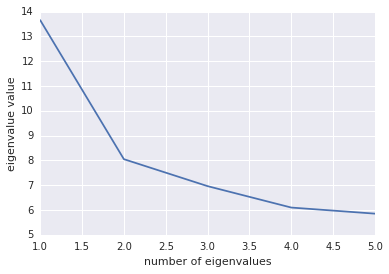

In [74]:
#plotting the first k singular values

plt.plot(range(1,len(s)+1),s[::-1])
plt.ylabel('eigenvalue value')
plt.xlabel('number of eigenvalues')

#### Projecting the dataset

Again, we project in all pairwise dimensions to visualize the behavior of our data on all 2-dimensional spaces we consider.

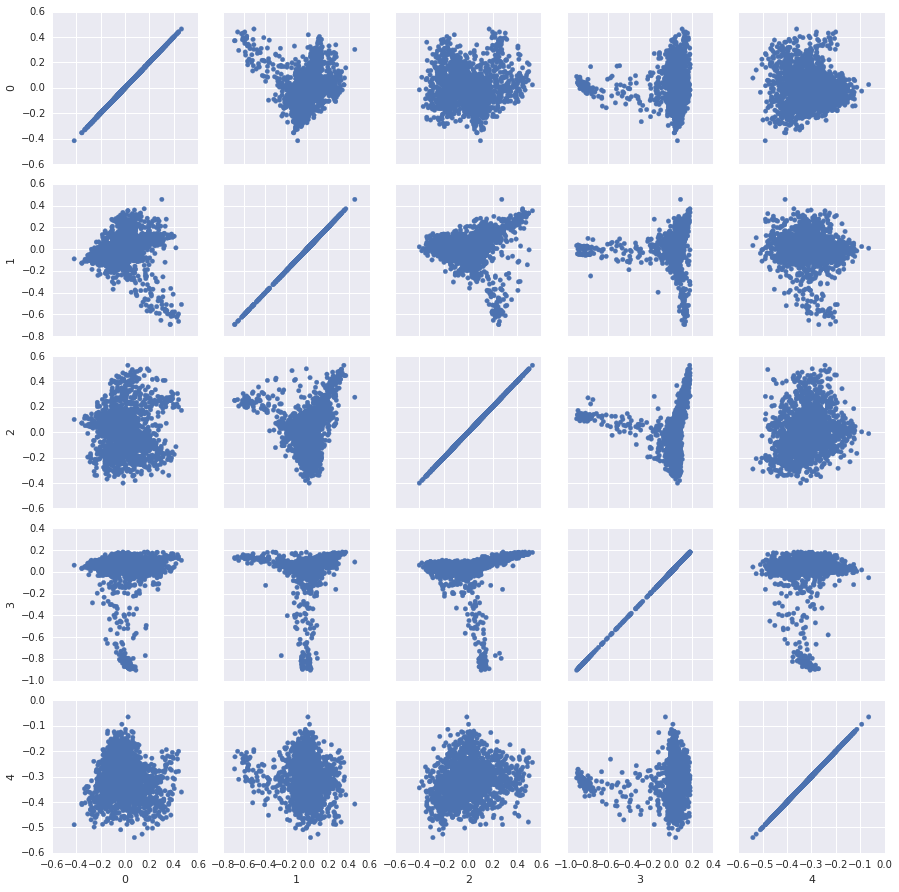

In [75]:
Xk = U*sp.sparse.diags(s,0)
X_df = pd.DataFrame(Xk)
g = sns.PairGrid(X_df)
g.map(plt.scatter)

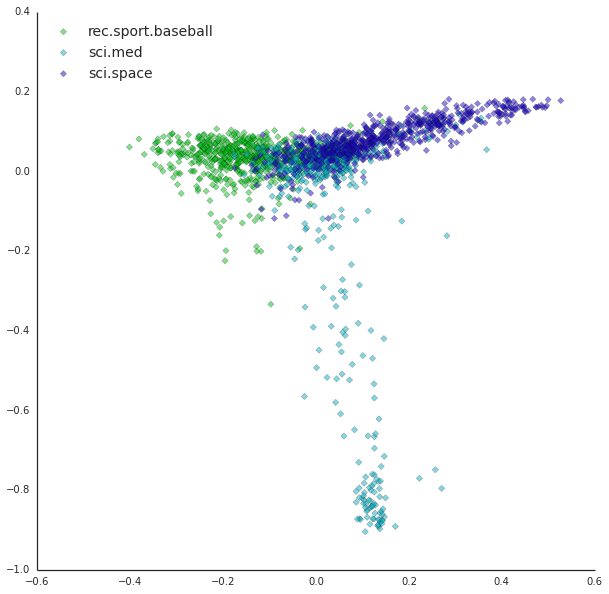

In [76]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(1,1,figsize=(10,10))
    cmap = sns.hls_palette(n_colors=6, h=0.35, l=0.4, s=0.9)
    for i, label in enumerate(set(news_data.target)):
        point_indices = np.where(news_data.target == label)[0]
        point_indices = point_indices.tolist()
        plt.scatter(Xk[point_indices,2], Xk[point_indices,3], s=20, alpha=0.5, c=cmap[i], marker='D',
label=news_data.target_names[i])
        plt.legend(prop={'size':14}, loc=2)
    sns.despine()

#### Looking into the topics

(5, 366)


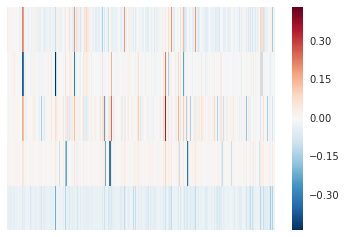

In [77]:
print V.shape
#print V
sns.heatmap(V,xticklabels=False, yticklabels=False, linewidths=0)

### Clustering the projected documents

In [78]:
vectorsk = U[:,2:4]*sp.sparse.diags(s[2:4],0)
print vectorsk.shape, type(vectorsk)
k=3
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=10, random_state=0)
kmeans.fit_predict(vectorsk)
centroidsk = kmeans.cluster_centers_
labelsk = kmeans.labels_
errork = kmeans.inertia_

(1784, 2) <type 'numpy.ndarray'>


In [79]:
ri = metrics.adjusted_rand_score(labelsk,news_data.target)
print ri

0.290245156864


## Other methods for projecting the data of the same data; Truncated SVD

http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html#sklearn.decomposition.TruncatedSVD

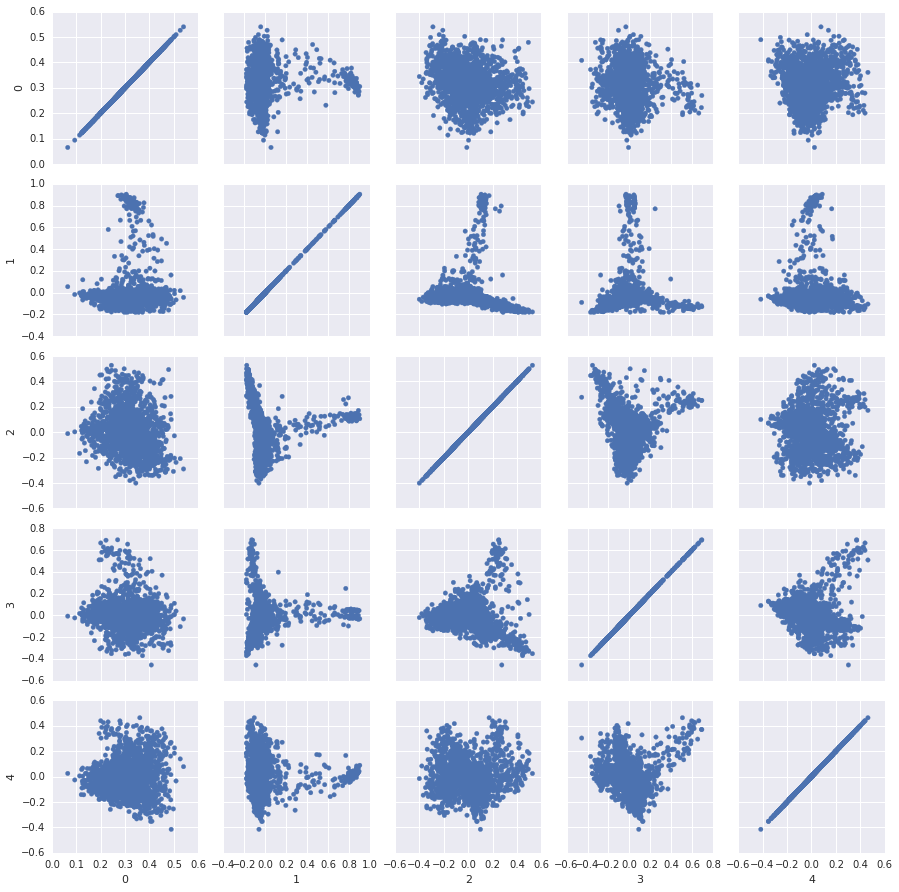

In [80]:
k = 5
tsvd = TruncatedSVD(n_components=k)
Xk = tsvd.fit_transform(vectors)

X_df = pd.DataFrame(Xk)
g = sns.PairGrid(X_df)
g.map(plt.scatter)

In [81]:
k = 10
tsvd = TruncatedSVD(n_components=k)
Xk = tsvd.fit_transform(vectors)
k=4
kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1, random_state=0)
kmeans.fit_predict(vectorsk)
centroids = kmeans.cluster_centers_
labels = kmeans.labels_
error = kmeans.inertia_
ri = metrics.adjusted_rand_score(labels,news_data.target)
print ri

0.345509851469


In [ ]:
# Code for setting the style of the notebook
from IPython.core.display import HTML
def css_styling():
    styles = open("../theme/custom.css", "r").read()
    return HTML(styles)
css_styling()